In [41]:
from datascience import *
from datascience.predicates import are
import numpy as np
import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [21]:
import pyspark
sc = pyspark.SparkContext('local[*]')

In [33]:
THRESHOLD = 0.9
WINDOW = 10

In [3]:
dna = "ACGT"

comp = {
    'A': 'T',
    'T': 'A',
    'C': 'G',
    'G': 'C',
}

def revcomp(seq):
    return ''.join(comp[a] for a in reversed(seq))

def make_seq(k):
    return ''.join(dna[randint(0, 3)] for i in range(k))

def perc_id(s1, s2):
    assert len(s1) == len(s2)
    matches = sum(
        1
        for i in range(len(s1))
        if s1[i] == s2[i]
    )
    return matches / float(len(s1))

def calc_synteny(s1, s2, k, threshold):
    mat = []
    for i in range(len(s1) - k):
        for j in range(len(s2) - k):
            window1 = s1[i:i + k]
            window2 = s2[j:j + k]
            score1 = perc_id(window1, window2)
            score2 = perc_id(window1, revcomp(window2))
            max_score = max(score1, score2)
            if max_score > threshold:
                mat.append((i, j, max_score))
    return mat

In [38]:
def calc_match(row):
    (i, s1), (j, s2) = row
    score1 = perc_id(s1, s2)
    score2 = perc_id(s1, revcomp(s2))
    max_score = max(score1, score2)
    
    return i, j, max_score

In [13]:
with open('synteny/data/s1.txt', 'r') as f:
    genome1 = f.readline()
with open('synteny/data/s2.txt', 'r') as f:
    genome2 = f.readline()
genome1

'CCGCAAAACTAGCAACCAGGATGGGGGCGGTGCGAGCACGTACAATCGTGTGAACAGTTTCTCCAGGCCAGGGGCCAAATCGAAAATACCAGCAGCCTAAGACGCACAGCAAAGAGTTATAGCGGTGATTCGCCTCTTTCACCCTGTCACGGCGAGGTTATACTGTACGTGACGCTACAAGAGGGACTCGGACACTCCTCCACTCGTACCATGAGGTGCGTTCCTTCGACGCGCTCTCTCGCCATAACGCGCCTGTTACTGTGCGTCCTGGGACTAGGCTGCTCGAACGGACAAAACCCCCATTAAACCAACCCCTGCAAATGGTCGCATATGTAATGGGTTATTCCATATTTGCGGAACTACCAACAGAGTTAGATGCCGTGATATCAGACTGACATGGTCGCTCGAGATCGGTAAAGCCTTAATATCATTTGCCGGTTGTGTGAGGGAAGACTATACGATACTGACGCCAAAGCATTAAGCTACACGAGGTTTCCTCTGTCCGGGTAGTTACCAATATGACATTTTCTGCAACTGTATGCTGCACGCAGGGACATAGGGTGAGTGACATACTGTGACCCACTGGCCTTATCAGGTAACGGGTAGTCCGTAGCGGTAGGGTGAACAGACCCTAATCGAGACAGCATAGAACGAACACATCCGCCCGTCATCCAAGTTTTTCTGAATCCTTGAATAGCCATCAGGCTCGCCTGGGAACGTTTCCTCGAGAAACATCTTGTAAGGGACCTAGGAAGATTAGTTCTGGCAAAAGAGGTTCTAAGAAAATAGGGAGACGTGGAGACTGTATTCCCAGTACTCTATAGTACACATAACGGCGAATTATAAGTTCTGTGCGATGGTGTGATCTCGTCTTGCCCATGCCGAGCACAGCTGAGAGGACCGTCCGTCGAACCTCCACACGTATCATAGGCGCTGGTTGCATATACGCAAAGAAAGAGCGGACCTGAAACCAACTCCAACGGTCGCACTCATATAGAG

In [64]:
i_range = range(len(genome1) - WINDOW)
j_range = range(len(genome2) - WINDOW)
i_range, j_range

(range(0, 1990), range(0, 1990))

In [66]:
windows1 = [(i, genome1[i:i + WINDOW]) for i in i_range]
windows2 = [(j, genome2[j:j + WINDOW]) for j in j_range]

In [67]:
rdd1 = sc.parallelize(windows1)
rdd2 = sc.parallelize(windows2)

result = (rdd1.cartesian(rdd2)
    .map(calc_match)
    .filter(lambda row: row[2] >= THRESHOLD)
    .collect()
)

In [68]:
tabled = Table(['i', 'j', 'score']).with_rows(result)
tabled

i,j,score
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
5,5,1
6,6,1
6,357,0.9
7,7,1
8,8,1


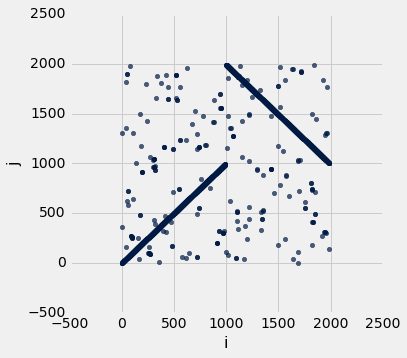

In [69]:
tabled.select('i', 'j').sort('i').scatter('i')